***
### This is a companion code for the paper  
# "LinG3D: Visualizing the Spatio-Temporal Dynamics of Clonal Evolution" 
A. Hu, A.M.E. Ojwang', K.D. Olumoyin, and K.A. Rejniak

This code generates the 3D lineage tree of all clones including  
only those cells that survived to the end of simulation. 

The following parameters needs to be specified:  
  pathdata -- directory with input data  
  NumberClones -- total number of clones in the data  
  
It requires the following data in the pathdata/data/ directory:  
  cell_history.txt -- file with info about each cell  
  cellID_##.txt    -- cell IDs in a file with index number ##  
  cellXY_##.txt    -- cell coordinates in a file with index ##  
  drug.txt         -- concentration of a drug for background  
  
The following parameters are project-dependent and should be  
specified for a given project:  
  xmin,xmax,ymin,ymax -- dimensions of the spacial domain  
  tmin, tmax          -- dimensions of the temporal domain  
  fileStep            -- frequency of the sampled data

for the examples discussed in the paper use:  
example 1: pathdata='exampleB05';  NumberClones=9  
example 2: pathdata='exampleB005'; NumberClones=147  

October 31, 2022
***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
import matplotlib as mpl
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits import mplot3d # to make interactive 3d plots
import os

%matplotlib notebook

In [2]:
from platform import python_version
print(python_version())

3.10.6


In [3]:
# define a MATLAB-like patch function

def patch_b(ax, x, y, z, color='blue',alpha=0.25):
    pc = Poly3DCollection([list(zip(x,y,z))],linewidths=1,alpha=alpha)       
    pc.set_facecolor(color)                                                       
    ax.add_collection3d(pc)                         
    return pc

def patch_c(ax, x, y, z, color='cyan',alpha=0.25):
    pc = Poly3DCollection([list(zip(x,y,z))],linewidths=1,alpha=alpha)       
    pc.set_facecolor(color)                                                       
    ax.add_collection3d(pc)                         
    return pc

def patch_y(ax, x, y, z, color='yellow',alpha=0.25):
    pc = Poly3DCollection([list(zip(x,y,z))],linewidths=1,alpha=alpha)       
    pc.set_facecolor(color)                                                       
    ax.add_collection3d(pc)                         
    return pc

def patch_r(ax, x, y, z, color='red',alpha=0.25):
    pc = Poly3DCollection([list(zip(x,y,z))],linewidths=1,alpha=alpha)       
    pc.set_facecolor(color)                                                       
    ax.add_collection3d(pc)                         
    return pc

In [4]:

def DrawBackground(drug,tmax,timeStep,xmin,xmax,ymin,ymax):
    drugmin=np.min(np.min(drug)); drugmax=np.max(np.max(drug)); drugstep=(drugmax-drugmin)/4
    kk=tmax/timeStep
    (Nx,Ny)=drug.shape; hgx=(xmax-xmin)/Nx; hgy=(ymax-ymin)/Ny;
    
    for ii in range(1,Nx+1):
        for jj in range(1,Ny+1):
            
            if drug[ii-1,jj-1]>=drugmin and drug[ii-1,jj-1]<(drugmin+drugstep):
                aa=[xmin+(ii-1)*hgx, xmin+ii*hgx, xmin+ii*hgx, xmin+(ii-1)*hgx, xmin+(ii-1)*hgx]
                bb=[kk, kk, kk, kk, kk]
                cc=[ymin+(jj-1)*hgy, ymin+(jj-1)*hgy, ymin+jj*hgy, ymin+jj*hgy, ymin+(jj-1)*hgy]
                patch_b(ax, aa, bb, cc)
                
            elif drug[ii-1,jj-1]>=(drugmin+drugstep) and drug[ii-1,jj-1]<(drugmin+2*drugstep):
                aa=[xmin+(ii-1)*hgx, xmin+ii*hgx, xmin+ii*hgx, xmin+(ii-1)*hgx, xmin+(ii-1)*hgx]
                bb=[kk, kk, kk, kk, kk]
                cc=[ymin+(jj-1)*hgy, ymin+(jj-1)*hgy, ymin+jj*hgy, ymin+jj*hgy, ymin+(jj-1)*hgy]
                patch_c(ax, aa, bb, cc)
                
            elif drug[ii-1,jj-1]>=(drugmin+2*drugstep) and drug[ii-1,jj-1]<(drugmin+3*drugstep):
                aa=[xmin+(ii-1)*hgx, xmin+ii*hgx, xmin+ii*hgx, xmin+(ii-1)*hgx, xmin+(ii-1)*hgx]
                bb=[kk, kk, kk, kk, kk]
                cc=[ymin+(jj-1)*hgy, ymin+(jj-1)*hgy, ymin+jj*hgy, ymin+jj*hgy, ymin+(jj-1)*hgy]
                patch_y(ax, aa, bb, cc)
                
            else:
                aa=[xmin+(ii-1)*hgx, xmin+ii*hgx, xmin+ii*hgx, xmin+(ii-1)*hgx, xmin+(ii-1)*hgx]
                bb=[kk, kk, kk, kk, kk]
                cc=[ymin+(jj-1)*hgy, ymin+(jj-1)*hgy, ymin+jj*hgy, ymin+jj*hgy, ymin+(jj-1)*hgy]
                patch_r(ax, aa, bb, cc)
           

In [5]:
def DefineColorPalette():
    col = np.array([[255,0,255],[255,0,0],[0,255,255],[0,0,255],[0,255,0],[0,0,0],[255,191,0],\
                    [255,255,0],[191,255,0],[128,128,0],[255,182,193],[0,191,255],[0,128,255],\
                    [250,235,215],[128,0,255],[154,205,50],[255,0,128],[102,0,0],[102,77,0],\
                    [0,102,102],[204,204,255],[255,204,255],[153,204,255],[255,153,153],[0,153,0],\
                    [0,153,153],[153,0,77],[255,228,225],[128,0,0],[102,102,153],[153,255,204],\
                    [218,112,214],[255,128,0],[192,192,192],[128,128,128],[75,0,130],[165,42,42],\
                    [216,191,216],[220,20,60],[245,222,179],[255,99,71],[255,127,80],[205,92,92],\
                    [240,128,128],[233,150,122],[250,128,114],[255,160,122],[255,69,0],\
                    [255,140,0],[255,165,0],[255,215,0],[184,134,11],[218,165,32],[0,100,0],\
                    [255,240,245],[188,143,143],[255,248,220],[50,205,50],[144,238,144],\
                    [152,251,152],[143,188,143],[0,250,154],[0,255,127],[46,139,87],[102,205,170],\
                    [60,179,113],[32,178,170],[47,79,79],[0,128,128],[0,139,139],[240,230,140],\
                    [245,245,220],[224,255,255],[0,206,209],[255,228,181],[255,20,147],\
                    [175,238,238],[127,255,212],[176,224,230],[95,158,160],[70,130,180],\
                    [100,149,237],[222,184,135],[30,144,255],[238,232,170],[189,183,107],\
                    [107,142,35],[124,252,0],[127,255,0],[173,255,47],\
                    [178,34,34],[221,160,221],[255,235,205]])/255
    return col

In [6]:
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

<IPython.core.display.Javascript object>


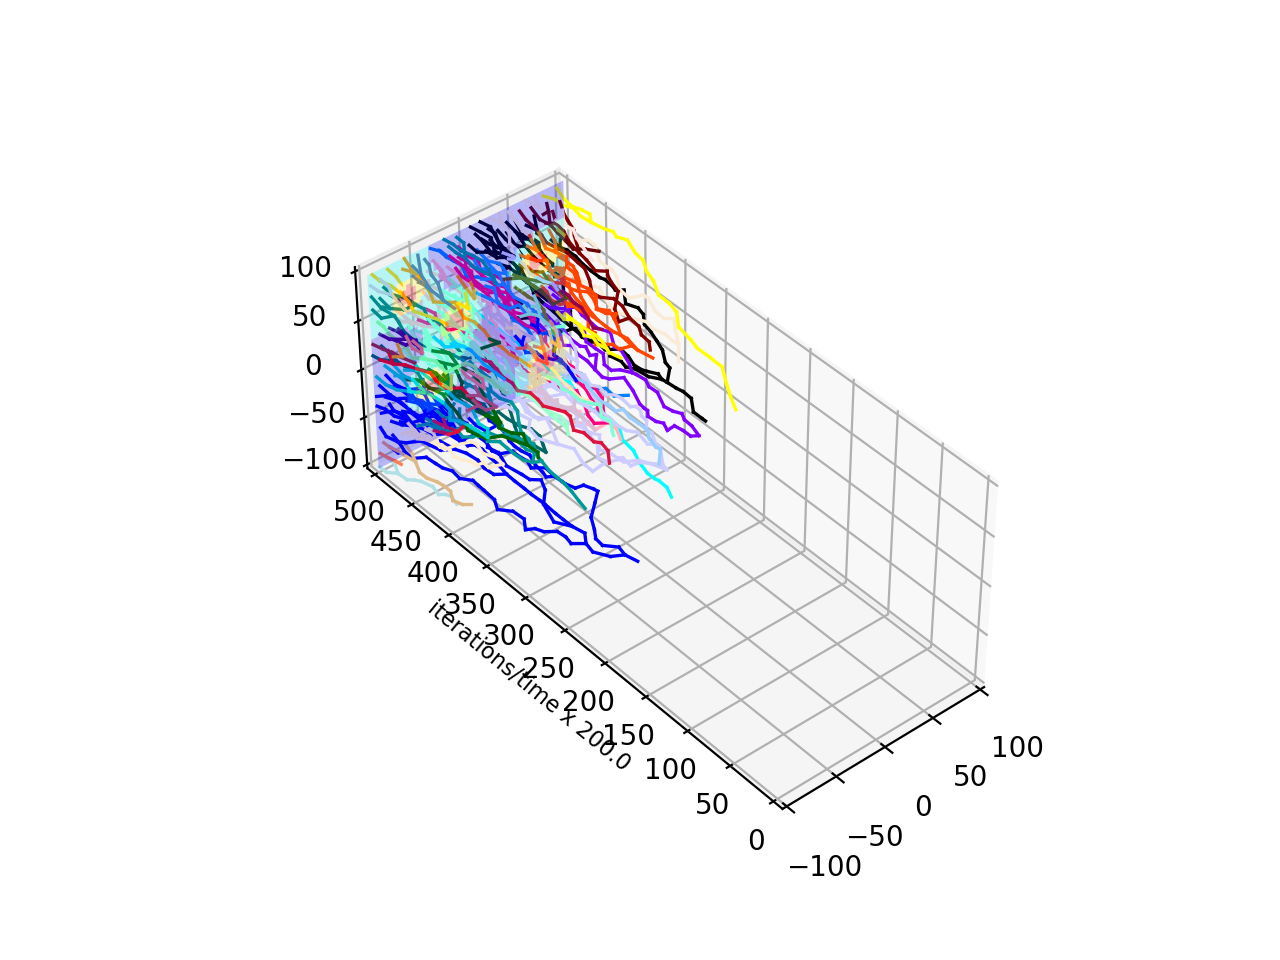

clone=0 of 147
clone=1 of 147
clone=2 of 147
... calculating
clone=3 of 147
... calculating
... calculating
clone=4 of 147
clone=5 of 147
... calculating
clone=6 of 147
clone=7 of 147
... calculating
clone=8 of 147
clone=9 of 147
clone=10 of 147
... calculating
clone=11 of 147
clone=12 of 147
... calculating
clone=13 of 147
... calculating
clone=14 of 147
... calculating
clone=15 of 147
clone=16 of 147
... calculating
clone=17 of 147
clone=18 of 147
clone=19 of 147
... calculating
clone=20 of 147
... calculating
... calculating
clone=21 of 147
clone=22 of 147
... calculating
clone=23 of 147
clone=24 of 147
clone=25 of 147
... calculating
clone=26 of 147
clone=27 of 147
clone=28 of 147
... calculating
clone=29 of 147
clone=30 of 147
... calculating
clone=31 of 147
clone=32 of 147
clone=33 of 147
clone=34 of 147
clone=35 of 147
clone=36 of 147
clone=37 of 147
... calculating
clone=38 of 147
... calculating
clone=39 of 147
clone=40 of 147
clone=41 of 147
clone=42 of 147
clone=43 of 147
cl

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')

def linG3DAliveAll():
##    pathdata = 'exampleB005'
##    NumberClones = 9
    
    pathdata = 'exampleB05'
    NumberClones = 147

    toPrint, IsGradient = 1, 1
    dataDirectory = '/data/'
    
    xmin=-100; xmax=100; ymin=xmin; ymax=xmax  # 2D domain boundaries
    tmin=0; tmax=100000                        # time/iteration boundaries
    timeStep=(tmax-tmin)/(2.5*(xmax-xmin))

    fileStep = 2000

    plt.grid()
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([tmin, tmax // timeStep])
    ax.set_zlim([ymin, ymax])
    
    col=DefineColorPalette()
    Ncol=col[:,0].shape[0]
    
    # draw background with drug gradient
    if IsGradient == 1:
        drug = np.loadtxt(pathdata + dataDirectory + 'drug.txt')
        DrawBackground(drug, tmax, timeStep, xmin, xmax, ymin, ymax)

    # load cell history file
    hist = np.loadtxt(pathdata + dataDirectory + 'cell_history.txt')
    # [cell ID, clone ID, mother ID, birth iter, div / death iter]

    # load indices of all survived cells
    cellID = np.loadtxt(pathdata + dataDirectory + 'cellID_' + str(tmax) + '.txt')
    # print(cellID.shape)
    
    # identify all survived cells for a given clone
    for cloneNum in range(NumberClones + 1):
        print('clone=' + str(cloneNum) + ' of ' + str(NumberClones))

        # identify all survived cells from a given clone
        indLast = []
        Nlast = 0
        
        for ii in range(len(cellID)):  # all cells in the last file
            if hist[int(cellID[ii])-1,1] == cloneNum:
                indLast.append(cellID[ii])
                Nlast += 1
        Numlast = Nlast
        for ii in range(Numlast):
            
            moNum = hist[int(indLast[ii])-1,2]
            while moNum > 0 and (hist[int(moNum)-1,1] == cloneNum):  # all predecesor cells
                indLast.append(moNum)
                Nlast += 1
                moNum = hist[int(moNum)-1,2]
        indLast = np.unique(indLast)  # remove repeated cells
        # print(indLast)
        
        # define matrix of line segments (3D branches) to draw
        matrix_to_draw = np.zeros((1, 6))  # [x1, t1, y1, x2, t2, y2] X - time - Y axes
        Nmatrix = 0
        
        for ii in range(len(indLast)):  # for every cell with index in indLast
            if ii % 100 == 0:
                print('... calculating')
                
            cellNum = hist[int(indLast[ii])-1,0]  # cell ID
            # print(cellNum)
            mothNum = hist[int(indLast[ii])-1,2]  # mother ID
            strtNum = hist[int(indLast[ii])-1,3]  # cell birth
            endNum = hist[int(indLast[ii])-1,4]
            endNum = max(tmax, min(endNum, tmax)) # cell div / death / tmax
            
            # find all appearances of the cellNum
            kkStart = fileStep * np.floor(strtNum / fileStep)  # initial file number
            kkEnd = fileStep * np.floor(endNum / fileStep)  # final file number
            kkStart = int(kkStart)
            kkEnd = int(kkEnd)
            # print(kkStart)
            
            for kk in range(kkEnd, kkStart, - fileStep):  # inspect all files
                # cell ID and cell XY from the first file
                fileMeID = np.loadtxt(pathdata + dataDirectory + 'cellID_' + str(kk) + '.txt')  
                fileMeXY = np.loadtxt(pathdata + dataDirectory + 'cellXY_' + str(kk) + '.txt')
                
                indMe = find(fileMeID == cellNum) # find current indices of cellID
                # print(indMe)
                
                fileMe2ID = np.loadtxt(pathdata + dataDirectory + 'cellID_' + str(kk - fileStep) + '.txt')
                fileMe2XY = np.loadtxt(pathdata + dataDirectory + 'cellXY_' + str(kk - fileStep) + '.txt')
                
                indMe2 = find(fileMe2ID == cellNum)  # find current indices of cellID
                # print(indMe2)
                
                if indMe.size == 0:
                    pass
                elif indMe2.size == 0:
                    # print(indMe)                  
                    while kkStart < hist[int(mothNum)-1,3]:  # find file with the grand-mother cell
                        mothNum = hist[int(mothNum)-1,2]
                    fileMe2ID = np.loadtxt(pathdata + dataDirectory + 'cellID_' + str(kkStart) + '.txt')
                    fileMe2XY = np.loadtxt(pathdata + dataDirectory + 'cellXY_' + str(kkStart) + '.txt')
                    
                    indMe2 = find(fileMe2ID == mothNum)  # find current indices of mother cellID
                    # print(indMe2)
                    if indMe2.size == 0:
                        pass
                    else:
                        matrix_to_draw = np.row_stack((matrix_to_draw, np.zeros((1, 6))))
                        matrix_to_draw[Nmatrix, :] = [fileMeXY[indMe][0][0], kkStart + fileStep,
                                                      fileMeXY[indMe][0][1], fileMe2XY[indMe2][0][0],
                                                      kkStart, fileMe2XY[indMe2][0][1]]
                        Nmatrix += 1  # save branch to draw [x1,t1,y1,x2,t2,y2]
                else:
                    matrix_to_draw = np.row_stack((matrix_to_draw, np.zeros((1, 6))))
                    matrix_to_draw[Nmatrix, :] = [fileMe2XY[indMe2][0][0], kk - fileStep,
                                                  fileMe2XY[indMe2][0][1], fileMeXY[indMe][0][0],
                                                  kk, fileMeXY[indMe][0][1]]
                    Nmatrix += 1  # save branch to draw [x1,t1,y1,x2,t2,y2]

        

        # drawing clones
        NumCol = cloneNum % Ncol  # clone color
        #plt.title('clone=' + str(cloneNum))
        plt.ylabel('iterations/time x ' + str(timeStep),fontsize=8)

        for ii in range(Nmatrix):
            x = [matrix_to_draw[ii][0], matrix_to_draw[ii][3]]
            y = [matrix_to_draw[ii][1], matrix_to_draw[ii][4]]
            y = [yi / timeStep for yi in y]
            z = [matrix_to_draw[ii][2], matrix_to_draw[ii][5]]
            ax.plot(x, y, z, c=col[NumCol][:3],linewidth=1.2)
        ax.view_init(40,-130)
        ax.set_box_aspect([1,2.5,1])
        ax.set_xticks([-100,-50,0,50,100])
        ax.set_yticks([500,450,400,350,300,250,200,150,100,50,0])
        ax.set_zticks([-100,-50,0,50,100])
        ax.set_ylim(0,500)

            
    #plt.title('final 3D traces of the survived clones')
    if toPrint==1:
        plt.savefig(pathdata + "/tree_alive_combined.jpg", dpi=300)
    
    plt.show()        
                    
if __name__ == '__main__':
    linG3DAliveAll()